In [26]:
import warnings
warnings.filterwarnings("ignore")
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [27]:
product = pd.read_pickle('./datasets/train_labeled_product_series.pkl')
meta = pd.read_pickle('./datasets/train_meta_series.pkl')
dt = pd.merge(left = product, right = meta, left_on = 'date', right_on= 'date')

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


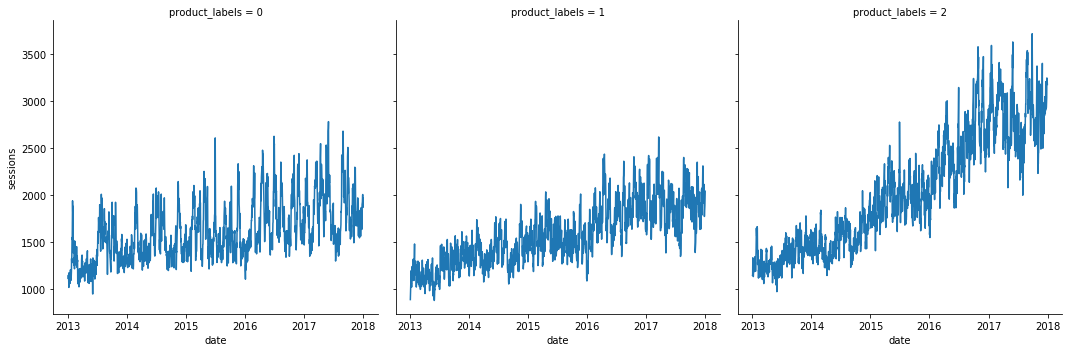

In [9]:
import seaborn as sns
dt_plot = dt.groupby(['date','product_labels'])[['sessions']].mean().reset_index()
dt_plot.product_labels = dt_plot.product_labels.astype('category')
sns.relplot(data = dt_plot, kind = 'line', x = 'date', y = 'sessions', col = 'product_labels')

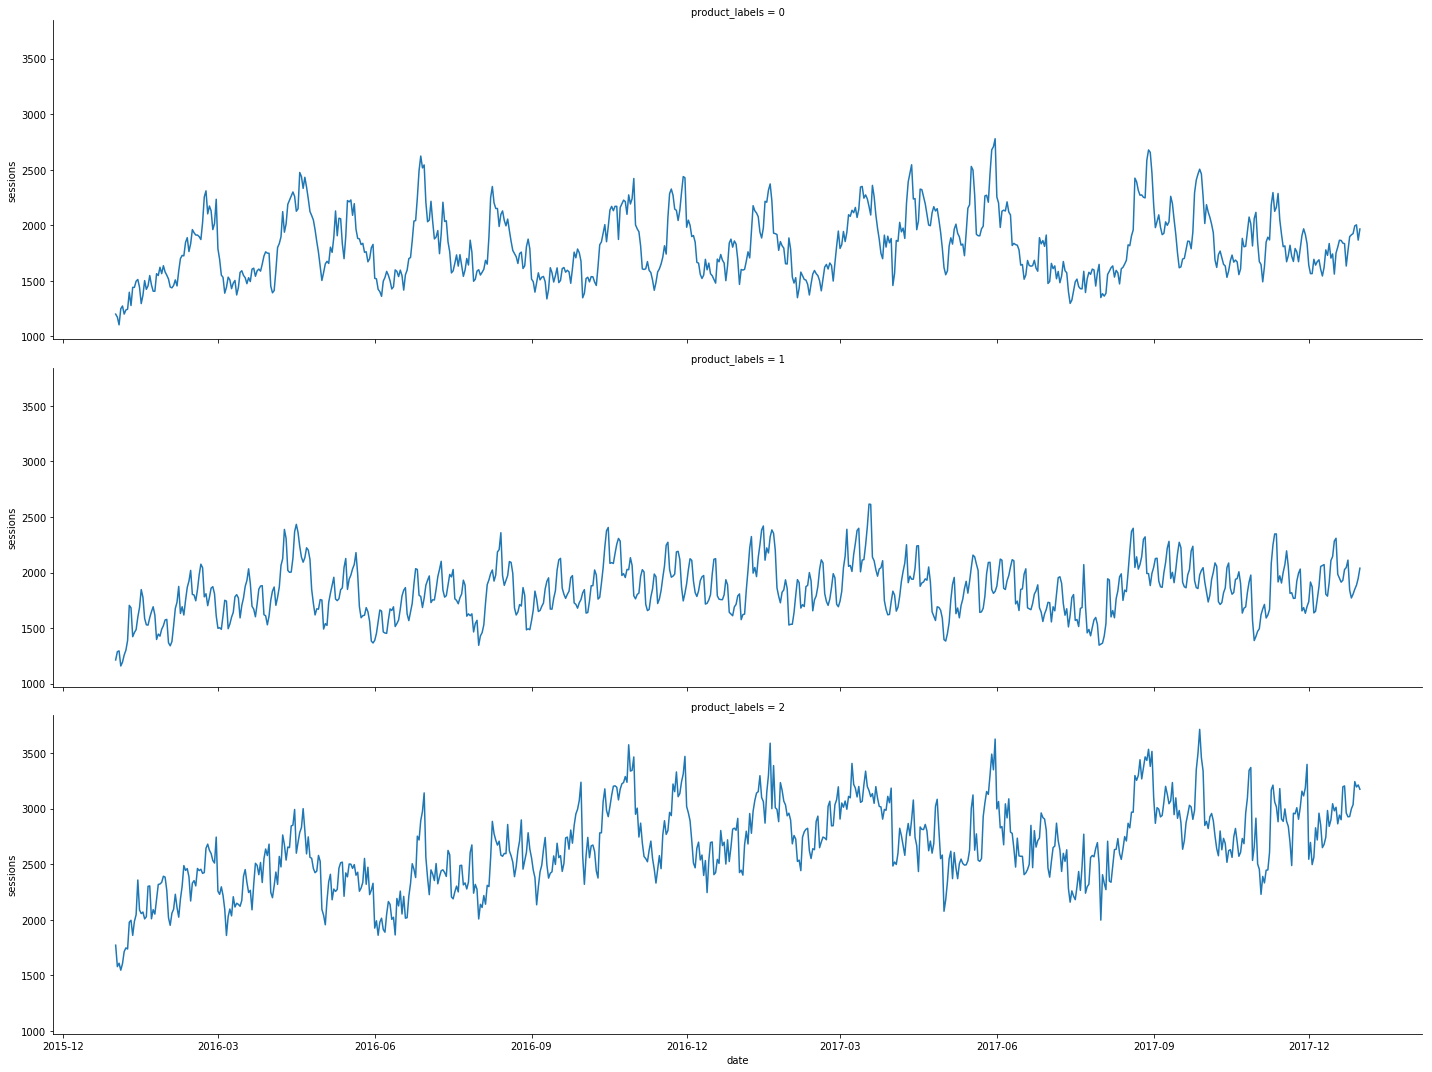

In [25]:
from datetime import datetime
dt_plot = dt.groupby(['date','product_labels'])[['sessions']].mean().reset_index().set_index('date')
dt_plot.product_labels = dt_plot.product_labels.astype('category')
dt_plot2 = dt_plot.loc[datetime(2016,1,1):,:].copy().reset_index()
sns.relplot(data = dt_plot2, kind = 'line', x = 'date', y = 'sessions', row = 'product_labels', aspect=4)

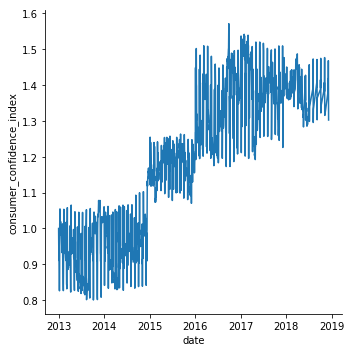

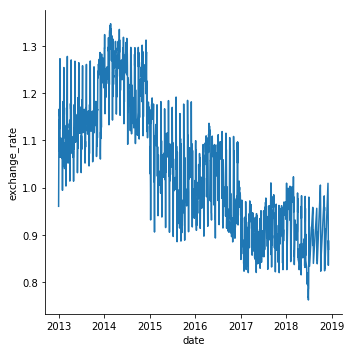

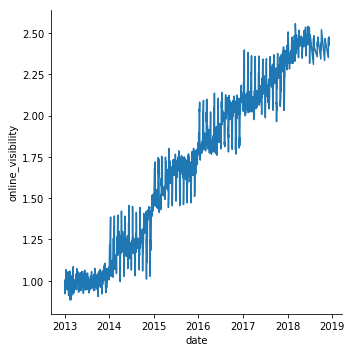

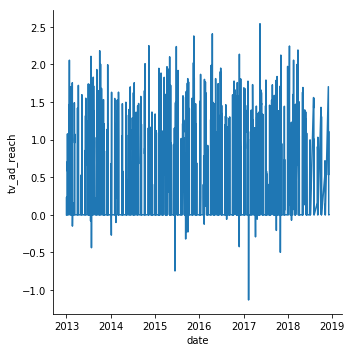

In [13]:
for i in meta.columns[1:-1]:
    sns.relplot(data = meta, x = 'date', y = i, kind = 'line')

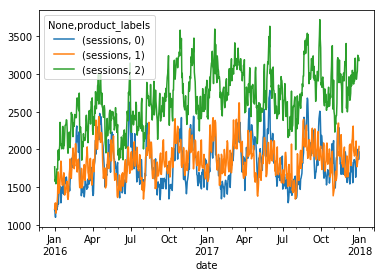

In [46]:
ys = dt.groupby(['date','product_labels'])[['sessions']].mean()#.reset_index().set_index('date').iloc[datetime(2016,1,1):,:]
#y0=ys.iloc[:,0]
#ys.iloc[:,0].plot()
y = ys.unstack().loc[datetime(2016,1,1):,:].copy()
ys.unstack().loc[datetime(2016,1,1):,:].plot()

In [62]:
# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 2) 
d = range(0, 2)
M = [7,31,122]
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], x[3]) for x in list(itertools.product(p, d, q, M))]

In [ ]:
resultats = {}
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(
                                        endog = y.iloc[:,0],# exog=pd.get_dummies(meta.iloc[:1200,1:]).values,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False
                                        ,enforce_invertibility=False
                                       )

        results = mod.fit()
        name = '{}'.format(param, param_seasonal)
        resultats.update(name=results.aic)
        print('ARIMA{}x{}30 - AIC:{}'.format(param, param_seasonal, results.aic))
res = [(v,k) for k,v in resultats.items()]
res.sort()
print(res[::-1])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 0, 7)30 - AIC:13048.771525565513
ARIMA(0, 0, 0)x(0, 0, 0, 31)30 - AIC:13048.771525565513
ARIMA(0, 0, 0)x(0, 0, 0, 122)30 - AIC:13048.771525565513
ARIMA(0, 0, 0)x(0, 0, 1, 7)30 - AIC:12095.71540391082


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 31)30 - AIC:11753.602106879505


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 122)30 - AIC:10267.91182782231
ARIMA(0, 0, 0)x(0, 1, 0, 7)30 - AIC:10281.29273508623


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 0, 31)30 - AIC:10424.049320655897


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 0, 122)30 - AIC:9072.842916898038


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 7)30 - AIC:10154.363715795567


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 31)30 - AIC:9574.01236503294


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 122)30 - AIC:7064.018968543708


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 0, 7)30 - AIC:10293.925511183947
ARIMA(0, 0, 0)x(1, 0, 0, 31)30 - AIC:10435.851248696908


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 0, 122)30 - AIC:9088.127480920695


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 7)30 - AIC:10255.237230048493


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 31)30 - AIC:10163.963313289925


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 122)30 - AIC:8871.080283554718
ARIMA(0, 0, 0)x(1, 1, 0, 7)30 - AIC:10186.370479875208


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 0, 31)30 - AIC:9800.206250268617


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 0, 122)30 - AIC:7075.620950954795


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 7)30 - AIC:9986.197939893382


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 31)30 - AIC:9571.43272155845


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 122)30 - AIC:7050.554308978592


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 0, 7)30 - AIC:12078.063872525574
ARIMA(0, 0, 1)x(0, 0, 0, 31)30 - AIC:12078.063872525574


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 0, 122)30 - AIC:12078.063872525574
ARIMA(0, 0, 1)x(0, 0, 1, 7)30 - AIC:11307.966146810233


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 31)30 - AIC:10952.095537732002


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 122)30 - AIC:9525.138256192356


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 0, 7)30 - AIC:9719.351463989091
ARIMA(0, 0, 1)x(0, 1, 0, 31)30 - AIC:9780.267204662221


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 0, 122)30 - AIC:8494.228792051754


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 7)30 - AIC:9503.753175248883


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 31)30 - AIC:8964.949592676267


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 122)30 - AIC:6617.03795769597


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 7)30 - AIC:9743.687604037652


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 31)30 - AIC:9802.66306997737


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 122)30 - AIC:8521.638723557058


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 7)30 - AIC:9592.7882294989
ARIMA(0, 0, 1)x(1, 0, 1, 31)30 - AIC:9415.173715161032


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 122)30 - AIC:8317.897689434249


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 0, 7)30 - AIC:9612.662743748097


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 0, 31)30 - AIC:9210.166258001478


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 0, 122)30 - AIC:6656.625940963417


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 7)30 - AIC:9391.980811205358


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 31)30 - AIC:8964.26933740661


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 122)30 - AIC:6617.029454452441


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 0, 0, 7)30 - AIC:9119.941161830677
ARIMA(0, 1, 0)x(0, 0, 0, 31)30 - AIC:9119.941161830677
ARIMA(0, 1, 0)x(0, 0, 0, 122)30 - AIC:9119.941161830677
ARIMA(0, 1, 0)x(0, 0, 1, 7)30 - AIC:8995.181449527277


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 31)30 - AIC:8748.492008190027


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 122)30 - AIC:7626.755083670623
ARIMA(0, 1, 0)x(0, 1, 0, 7)30 - AIC:9285.997634152587


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 0, 31)30 - AIC:9182.645526587607


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 0, 122)30 - AIC:8019.728820894604


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 7)30 - AIC:8686.71428970838


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 31)30 - AIC:8435.533486990818


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 122)30 - AIC:6241.072540209585


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 0, 7)30 - AIC:8986.152693242664
ARIMA(0, 1, 0)x(1, 0, 0, 31)30 - AIC:8759.626793377221


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 0, 122)30 - AIC:7638.4449853554415


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 7)30 - AIC:8774.627755553078


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 31)30 - AIC:8748.649082764907


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 122)30 - AIC:7625.213790253949
ARIMA(0, 1, 0)x(1, 1, 0, 7)30 - AIC:8990.919835851253


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 0, 31)30 - AIC:8601.785239423094


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 0, 122)30 - AIC:6281.962152409778


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 7)30 - AIC:8686.051848079976


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 31)30 - AIC:8436.930190328478


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 122)30 - AIC:6241.263892306142


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 0, 7)30 - AIC:9106.99834123126
ARIMA(0, 1, 1)x(0, 0, 0, 31)30 - AIC:9106.99834123126
ARIMA(0, 1, 1)x(0, 0, 0, 122)30 - AIC:9106.99834123126


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 7)30 - AIC:8979.666165792416


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 31)30 - AIC:8734.487091037045


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 122)30 - AIC:7614.07919586753
ARIMA(0, 1, 1)x(0, 1, 0, 7)30 - AIC:9269.488397485893


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 0, 31)30 - AIC:9161.434366037012


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 0, 122)30 - AIC:7996.652611711137


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 7)30 - AIC:8673.156134821711


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 31)30 - AIC:8422.75489759164


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 122)30 - AIC:6230.521977016653


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 0, 7)30 - AIC:8983.52627153182
ARIMA(0, 1, 1)x(1, 0, 0, 31)30 - AIC:8757.027866318957


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 0, 122)30 - AIC:7636.834825175936


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 7)30 - AIC:8764.459166652867


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 31)30 - AIC:8734.945410567325


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 122)30 - AIC:7612.464556456531


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 7)30 - AIC:8988.085120085612


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 31)30 - AIC:8603.718736236875


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 122)30 - AIC:6283.252874184847


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 7)30 - AIC:8672.90476711386


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 31)30 - AIC:8423.619523393088


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 122)30 - AIC:6230.798213331773


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 0, 7)30 - AIC:9132.961846177384


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 0, 31)30 - AIC:9132.961846177384


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 0, 122)30 - AIC:9132.961846177384


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 7)30 - AIC:9010.369590422571


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 31)30 - AIC:8761.651883806924


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 122)30 - AIC:7640.934158940848
ARIMA(1, 0, 0)x(0, 1, 0, 7)30 - AIC:9253.454122619118


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 0, 31)30 - AIC:9165.860996170806


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 0, 122)30 - AIC:8006.49548488971


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 7)30 - AIC:8678.065473461202


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 31)30 - AIC:8416.401891552643


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 122)30 - AIC:6231.45236702956


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 0, 7)30 - AIC:8986.979014986122


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 0, 31)30 - AIC:8761.032623135667


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 0, 122)30 - AIC:7639.859678222996


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 7)30 - AIC:8822.910762995654


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 31)30 - AIC:8761.772281700949


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 122)30 - AIC:7639.025527804057


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 0, 7)30 - AIC:8962.172479353965


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 0, 31)30 - AIC:8574.744492686632


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 0, 122)30 - AIC:6258.853723043301


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 7)30 - AIC:8678.244712577913


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 31)30 - AIC:8417.782319196638


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 122)30 - AIC:6232.157230306095


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 0, 7)30 - AIC:9120.165302469586
ARIMA(1, 0, 1)x(0, 0, 0, 31)30 - AIC:9120.165302469586
ARIMA(1, 0, 1)x(0, 0, 0, 122)30 - AIC:9120.165302469586


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 7)30 - AIC:8994.223558543521


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 31)30 - AIC:8747.296241966336


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 122)30 - AIC:7627.709210185449
ARIMA(1, 0, 1)x(0, 1, 0, 7)30 - AIC:9225.590430034465


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 0, 31)30 - AIC:9136.50008881316


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 0, 122)30 - AIC:7974.051189239341


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 7)30 - AIC:8662.2216823099


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 31)30 - AIC:8397.555977561475


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 122)30 - AIC:6218.508852068372


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 7)30 - AIC:8984.025251061688


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 31)30 - AIC:8758.252087178933


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 122)30 - AIC:7638.135053854177


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 7)30 - AIC:8750.747227056983


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 31)30 - AIC:8747.65117817089


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 122)30 - AIC:7625.7484036189335


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 7)30 - AIC:8953.769444335598


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 31)30 - AIC:8575.87498095876


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 122)30 - AIC:6260.62997754635


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 7)30 - AIC:8663.288536846725


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 31)30 - AIC:8398.056143726542


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [15]:
ys.iloc[:,0].shape

(1826,)

In [58]:
pd.get_dummies(meta.iloc[:1200,1:]).values

array([[1.        , 0.96052837, 0.99540838, ..., 1.        , 0.        ,
        0.        ],
       [1.01272878, 0.99432726, 1.00972299, ..., 1.        , 0.        ,
        0.        ],
       [1.01698178, 1.00342224, 0.99761468, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [1.33917109, 1.09591237, 1.86715071, ..., 1.        , 0.        ,
        0.        ],
       [1.3175615 , 1.10524793, 1.78287741, ..., 1.        , 0.        ,
        0.        ],
       [1.32920897, 1.07766801, 1.80176236, ..., 1.        , 0.        ,
        0.        ]])

In [54]:
?sm.tsa.statespace.SARIMAX

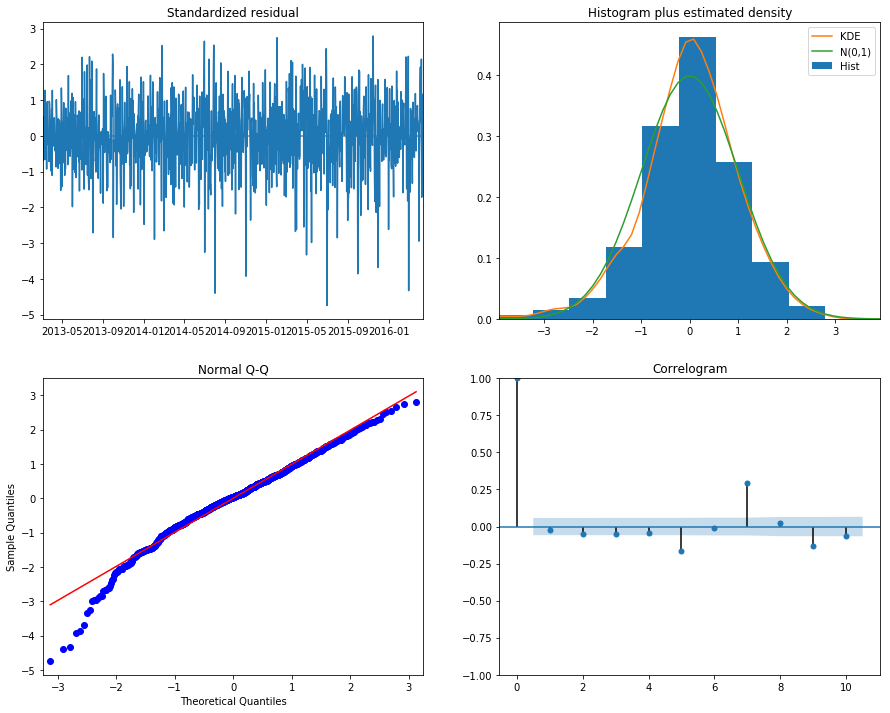

In [59]:
mod = sm.tsa.statespace.SARIMAX(endog = ys.iloc[:1200,0], exog=pd.get_dummies(meta.iloc[:1200,1:]).values,
    order=(1,1,1),
    seasonal_order=(1,1,1,30),
    enforce_stationarity=False
    ,enforce_invertibility=False)
results = mod.fit()
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [68]:
print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(1, 1, 1)x(1, 1, 1, 30)12 - AIC:13865.994280867619


In [61]:
pred = results.get_prediction(start=pd.to_datetime('2016-04-16'), dynamic=False, exog=pd.get_dummies(meta.iloc[1201:,1:]).values)
#pred_ci = pred.conf_int()

y_forecasted = pred.predicted_mean

ax = ys.iloc[1201:,0].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()



import math
# Compute the mean square error
mse = math.sqrt(((y_forecasted - ys.iloc[1201:,0]) ** 2).mean())
print('The Mean Root Squared Error of our forecasts is {}'.format(round(mse, 2)))

ValueError: Provided exogenous values are not of the appropriate shape. Required (2, 7), got (805, 7).

In [66]:
#?results.get_forecast(steps=500)
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500, exog=pd.get_dummies(meta.iloc[1201:1701,1:]).values)

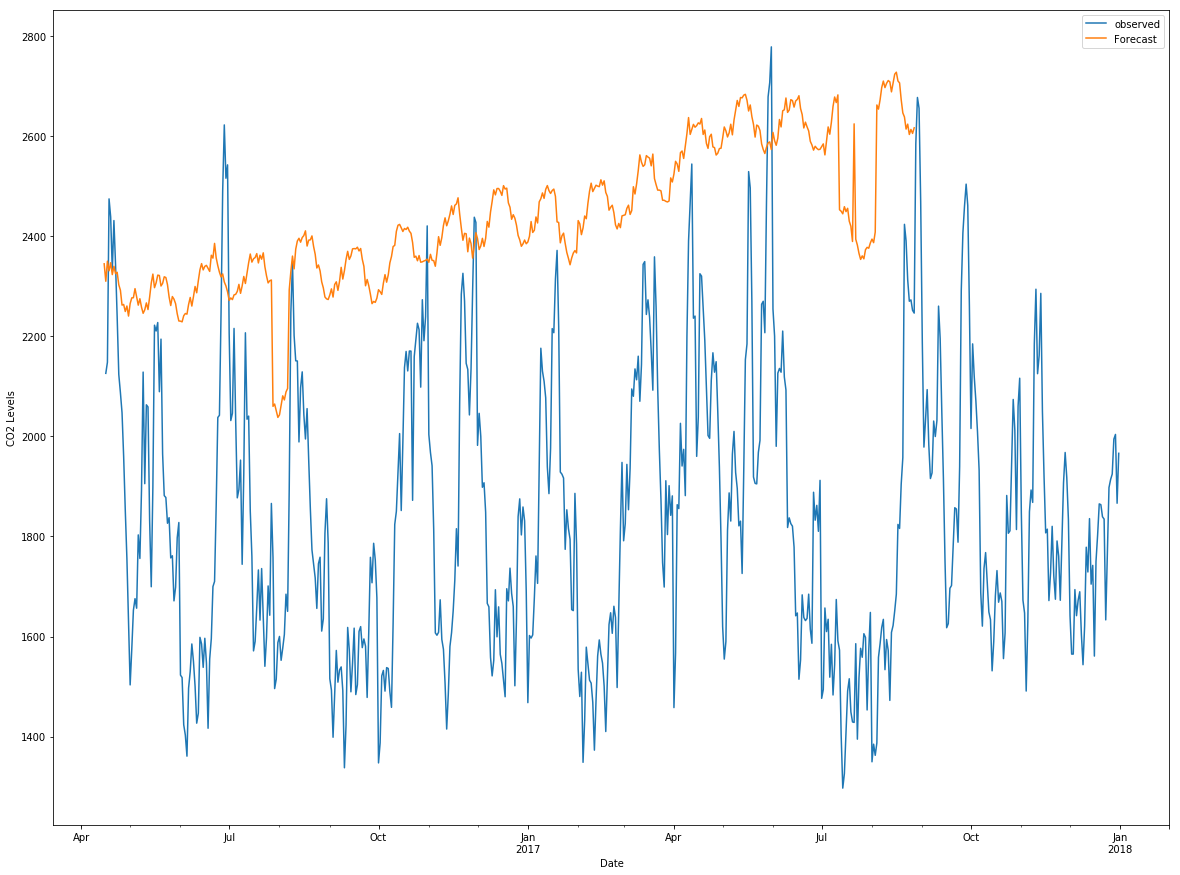

In [67]:
ax = ys.iloc[1201:,0].plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()